# Simple viewer for Grads files

In [1]:
filename = "attm102.ctl"

In [2]:
import numpy as np

In [3]:
f = open(filename, "r")
lines = f.read()
f.close

lines = lines.replace("\r", "")
lines = lines.split("\n")

In [4]:
for line in lines:
    print(line)

DSET   ^attm102_%y4.grd                                                         
TITLE   Means/variances from run no. xxx  102                                   
UNDEF   9.999E+19                                                               
OPTIONS sequential template big_endian                                          
XDEF      96  LINEAR     0.000     3.750                                        
YDEF      48  LEVELS   -87.159   -83.479   -79.777   -76.070   -72.362   -68.652
   -64.942   -61.232   -57.521   -53.810   -50.099   -46.389   -42.678   -38.967
   -35.256   -31.545   -27.833   -24.122   -20.411   -16.700   -12.989    -9.278
    -5.567    -1.856     1.856     5.567     9.278    12.989    16.700    20.411
    24.122    27.833    31.545    35.256    38.967    42.678    46.389    50.099
    53.810    57.521    61.232    64.942    68.652    72.362    76.070    79.777
    83.479    87.159
ZDEF       8  LEVELS   925   850   700   500   300   200   100    30
TDEF       3  LINEA

In [5]:
metadata = {}
varsKeys = []
continuation = False
for line in lines:
    if not continuation:
        try:
            key, value = line.split(None, 1)
        except:
            key = line

        key = key.strip()
        
        if key in ["DSET", "TITLE", "OPTIONS"]:
            metadata[key] = value.strip()

        elif key == "UNDEF":
            metadata[key] = float(value)

        elif key in ["XDEF", "YDEF", "ZDEF", "TDEF"]:
            fields = line.split(None)
            linlev = fields[2]
            if linlev == "LINEAR":
                if key != "TDEF":
                    metadata[key] = np.arange(float(fields[3]), int(fields[1])*float(fields[4]), float(fields[4]))
                else:
                    nfields = int(fields[1])
                    tags = []
                    for i in range(nfields):
                        tag = fields[3]+i*('+'+fields[4])
                        tags.append(tag)
                    metadata[key] = tags
            elif linlev == "LEVELS":
                levels = list(map(float, fields[3:]))
                nlevels = int(fields[1])
                if len(levels) == nlevels:
                    metadata[key] = list(map(float, fields[3:]))
                else:
                    continuation = True
            else:
                print("Unknown data grid:", linlev)

        elif key == "VARS":
            metadata[key] = int(value)

        elif key != "ENDVARS" and key != "":
            fields = line.split(None, 3)
            metadata[key] = fields[3].strip()
            varsKeys.append([key,int(fields[1])])
                
    else:  # continuation line
        fields = line.split(None)
        levels += list(map(float, fields))
        if len(levels) == nlevels:
            metadata[key] = levels
            continuation = False

if len(varsKeys) != metadata["VARS"]:
    print("There is a problem with the VARS metadata")
    print("VARS is ",metadata["VARS"],"but found",len(varsKeys),"variables")

print(metadata)

print("Values for:")
print(varsKeys)

{'DSET': '^attm102_%y4.grd', 'TITLE': 'Means/variances from run no. xxx  102', 'UNDEF': 9.999e+19, 'OPTIONS': 'sequential template big_endian', 'XDEF': array([  0.  ,   3.75,   7.5 ,  11.25,  15.  ,  18.75,  22.5 ,  26.25,
        30.  ,  33.75,  37.5 ,  41.25,  45.  ,  48.75,  52.5 ,  56.25,
        60.  ,  63.75,  67.5 ,  71.25,  75.  ,  78.75,  82.5 ,  86.25,
        90.  ,  93.75,  97.5 , 101.25, 105.  , 108.75, 112.5 , 116.25,
       120.  , 123.75, 127.5 , 131.25, 135.  , 138.75, 142.5 , 146.25,
       150.  , 153.75, 157.5 , 161.25, 165.  , 168.75, 172.5 , 176.25,
       180.  , 183.75, 187.5 , 191.25, 195.  , 198.75, 202.5 , 206.25,
       210.  , 213.75, 217.5 , 221.25, 225.  , 228.75, 232.5 , 236.25,
       240.  , 243.75, 247.5 , 251.25, 255.  , 258.75, 262.5 , 266.25,
       270.  , 273.75, 277.5 , 281.25, 285.  , 288.75, 292.5 , 296.25,
       300.  , 303.75, 307.5 , 311.25, 315.  , 318.75, 322.5 , 326.25,
       330.  , 333.75, 337.5 , 341.25, 345.  , 348.75, 352.5 , 356.

In [6]:
grads_filename = filename[:-4]+"_"+metadata["TDEF"][0][-4:]+".grd"
print(grads_filename)

attm102_1979.grd


In [7]:
number_zeds = 0
for label, nzed in varsKeys:
    if nzed == 0:
        number_zeds +=1
    elif nzed == len(metadata["ZDEF"]):
        number_zeds += nzed
    else:
        print('Something unexpected happened')
number_values = len(metadata["XDEF"]) * len(metadata["YDEF"]) * len(metadata["TDEF"]) * number_zeds
print('number of values to be read is',number_values)
print('number of lines expected is',number_zeds)

number of values to be read is 1437696
number of lines expected is 104


Expecting 179712 lines * 8 values = 1437696

In [8]:
from scipy.io import FortranFile
data = {}
w, h = 8, 5;
values = [[0 for x in range(w)] for y in range(h)]

f = FortranFile(grads_filename, 'r', '>u4')
for label, nzed in varsKeys:
    if nzed == 0:
        values = []
        for it in range(len(metadata["TDEF"])):
            values.append(f.read_reals('>f4'))
        data[label] = values
    elif nzed == len(metadata["ZDEF"]):
        values = []
        for it in range(len(metadata["TDEF"])):
            for ized in range(nzed):
                values.append(f.read_reals('>f4'))
        values = np.stack(values, axis=0)
        data[label] = values
    else:
        print('Something unexpected happened')
f.close()
print(data)

{'GH': array([[ 8.7952496e+02,  8.8137830e+02,  8.8334375e+02, ...,
         8.0944647e+02,  8.1007056e+02,  8.1068750e+02],
       [ 1.5299567e+03,  1.5315533e+03,  1.5332560e+03, ...,
         1.4517664e+03,  1.4525076e+03,  1.4532118e+03],
       [ 2.9934231e+03,  2.9944011e+03,  2.9954734e+03, ...,
         2.9090283e+03,  2.9098101e+03,  2.9105413e+03],
       ...,
       [-8.8174933e-01, -1.0957080e+00, -1.3084548e+00, ...,
         1.8098174e+00,  1.8780378e+00,  1.9393727e+00],
       [-1.7206018e+00, -2.0593064e+00, -2.3841836e+00, ...,
         1.1578967e-01,  1.7833900e-01,  2.3691264e-01],
       [-1.7945702e+00, -1.9360722e+00, -2.0740266e+00, ...,
        -2.7171767e+00, -2.8219278e+00, -2.9105198e+00]], dtype=float32), 'TEMP': array([[-0.6192683 , -0.62305766, -0.6208038 , ...,  1.9245956 ,
         1.9769349 ,  2.0258076 ],
       [-1.0784962 , -1.08385   , -1.0786453 , ...,  2.5091438 ,
         2.5025978 ,  2.480035  ],
       [-2.1113465 , -2.1203263 , -2.108489  , .

In [9]:
print(metadata["VARS"])

41


In [10]:
metadata["XDEF"]

array([  0.  ,   3.75,   7.5 ,  11.25,  15.  ,  18.75,  22.5 ,  26.25,
        30.  ,  33.75,  37.5 ,  41.25,  45.  ,  48.75,  52.5 ,  56.25,
        60.  ,  63.75,  67.5 ,  71.25,  75.  ,  78.75,  82.5 ,  86.25,
        90.  ,  93.75,  97.5 , 101.25, 105.  , 108.75, 112.5 , 116.25,
       120.  , 123.75, 127.5 , 131.25, 135.  , 138.75, 142.5 , 146.25,
       150.  , 153.75, 157.5 , 161.25, 165.  , 168.75, 172.5 , 176.25,
       180.  , 183.75, 187.5 , 191.25, 195.  , 198.75, 202.5 , 206.25,
       210.  , 213.75, 217.5 , 221.25, 225.  , 228.75, 232.5 , 236.25,
       240.  , 243.75, 247.5 , 251.25, 255.  , 258.75, 262.5 , 266.25,
       270.  , 273.75, 277.5 , 281.25, 285.  , 288.75, 292.5 , 296.25,
       300.  , 303.75, 307.5 , 311.25, 315.  , 318.75, 322.5 , 326.25,
       330.  , 333.75, 337.5 , 341.25, 345.  , 348.75, 352.5 , 356.25])

In [11]:
metadata["TDEF"]

['1jan1979', '1jan1979+1mo', '1jan1979+1mo+1mo']

In [12]:
print(len(data["TMAX"][0]),len(metadata["XDEF"]),len(metadata["YDEF"]))

4608 96 48


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

In [32]:
heat = data["TMAX"][0].reshape(len(metadata["YDEF"]), len(metadata["XDEF"]))
lenX = len(metadata["XDEF"])
lenY = len(metadata["YDEF"])

In [15]:
import pandas as pd

In [33]:
df = pd.DataFrame(heat, index= metadata["YDEF"], columns=metadata["XDEF"])
#dfr = df.iloc[::-1]
# df

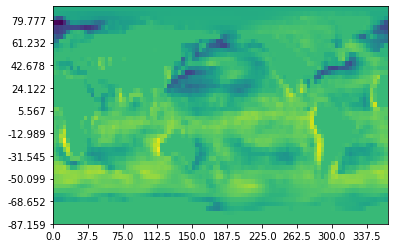

In [34]:
plt.pcolor(df)
plt.yticks(np.arange(0, lenY, 5), df.index[0::5])
plt.xticks(np.arange(0, lenX, 10), df.columns[0::10])
plt.show()